In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm
from typing import Tuple
import math

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


In [3]:
batch_size = 128
torch.manual_seed(50)

In [4]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, **kwargs)

testset = datasets.MNIST(root='./data', train=False,
                          download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size,
                         shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 266369247.42it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28828104.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 180453787.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11285858.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



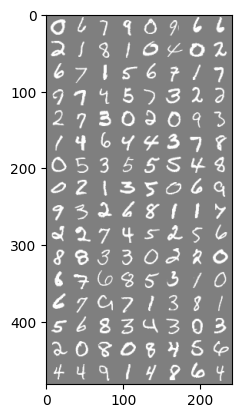

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [6]:
# encoder layer. Takes x as input and encodes it to a latent space
class LadderEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, latent_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.z_dim = latent_dim

        # hidden layers
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        self.batchnorm = nn.BatchNorm1d(self.out_dim)

        # latent layers
        self.mu = nn.Linear(self.out_dim, self.z_dim)
        self.var = nn.Linear(self.out_dim, self.z_dim)

    def forward(self, x):
        # hidden
        x = self.linear(x)
        x = F.leaky_relu(self.batchnorm(x), 0.1)

        # latent
        mu = self.mu(x)
        var = F.softplus(self.var(x))

        return x, mu, var


# decoder layer.
class LadderDecoder(nn.Module):
    def __init__(self, z1_dim, hidden_dim, z2_dim):
        super().__init__()

        self.linear = nn.Linear(z1_dim, hidden_dim)
        self.batchnrom = nn.BatchNorm1d(hidden_dim)

        self.mu = nn.Linear(hidden_dim, z2_dim)
        self.var = nn.Linear(hidden_dim, z2_dim)

    def forward(self, x):
        x = self.linear(x)
        x = F.leaky_relu(self.batchnrom(x), 0.1)

        mu = self.mu(x)
        var = F.softplus(self.var(x))

        return mu, var


# Final decoder layer.
class FinalLadderDecoder(nn.Module):
    def __init__(self, z_final, hidden_dim, input_dim):
        super().__init__()

        self.linear = nn.Linear(z_final, hidden_dim)
        self.recon = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = F.relu(self.linear(x))
        return F.sigmoid(self.recon(x))

In [7]:
class LadderVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dims):
        super().__init__()
        self.device = device
        self.data_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dims = latent_dims

        self.n_layers = len(latent_dims)

        neurons = [input_dim, *hidden_dims]

        encoder_layers = [LadderEncoder(neurons[i-1], neurons[i], latent_dims[i-1]) for i in range(1, len(neurons))]
        decoder_layers = [LadderDecoder(latent_dims[i], hidden_dims[i], latent_dims[i-1]) for i in range(1, len(hidden_dims))][::-1]

        self.encoder = nn.ModuleList(encoder_layers)
        self.decoder = nn.ModuleList(decoder_layers)
        self.recon = FinalLadderDecoder(latent_dims[0], hidden_dims[0], input_dim)

    # function to reparameterize. Same as in the standard VAE
    def reparameterize(self, mu, var):
        eps = torch.randn_like(var)
        std = torch.sqrt(var)
        return mu + eps * std

    # function to merge two gaussians, taken from the paper
    def merge_gaussian(self, mu1, var1, mu2, var2):
        precision1 = 1 / (var1 + 1e-8)
        precision2 = 1 / (var2 + 1e-8)

        new_mu = (mu1 * precision1 + mu2 * precision2) / (precision1 + precision2)
        new_var = 1 / (precision1 + precision2)
        return new_mu, new_var

    # function to compute the KL divergence
    def compute_kl(self, z, q_params, p_params = None):
        (mu, var) = q_params

        # compute log of gaussian
        qz = torch.sum(- 0.5 * math.log(2 * math.pi) - 0.5 * torch.log(var + 1e-8) - (z - mu)**2 / (2 * var + 1e-8), dim=-1)

        if p_params is None:
            # log of standard gaussian
            pz = torch.sum(-0.5 * math.log(2 * math.pi) - z**2 /2, dim=-1)
        else:
            (mu, var) = p_params
            pz = torch.sum(- 0.5 * math.log(2 * math.pi) - 0.5 * torch.log(var + 1e-8) - (z - mu)**2 / (2 * var + 1e-8), dim=-1)

        return qz - pz

    def forward(self, x):

        mu_var_lst = []
        latents = []

        # deterministic upward pass over all the encoding layers
        for layer in self.encoder:
            x, mu, var = layer(x)
            mu_var_lst.append((mu, var))

        # reparameterize using mu and var from last latent layer
        mu, var = mu_var_lst[-1]
        z = self.reparameterize(mu, var)
        latents.append(z)
        mu_var_lst = list(reversed(mu_var_lst))

        self.kl_divergence = 0
        self.kl_divergence_per_layer = []

        # stochastic downward pass recursively computing
        # both the approximate posterior and generative distributions
        for i, decoder in enumerate([-1, *self.decoder]):

            mu_d, var_d = mu_var_lst[i]

            if i == 0:
                # we are at the top, we have to compute the kl
                layer_kl = self.compute_kl(z, (mu_d, var_d))
                self.kl_divergence += layer_kl
                self.kl_divergence_per_layer.append(torch.sum(layer_kl))

            else:
                # otherwise we have to pass the z through the decoder
                # get the mu and var and merge them with the one we get in the previous step
                mu_t, var_t = decoder(z)
                merged_mu, merged_var = self.merge_gaussian(mu_d, var_d, mu_t, var_t)

                # and now we can sample them
                z = self.reparameterize(merged_mu, merged_var)
                latents.append(z)

                # and compute the kl
                layer_kl = self.compute_kl(z, (merged_mu, merged_var), (mu_t, var_t))
                self.kl_divergence += layer_kl
                self.kl_divergence_per_layer.append(torch.sum(layer_kl))

        # final decoder, i.e. reconstruction
        recon = self.recon(z)
        return recon, latents

    # function to sample
    def decode(self, z):
        for decoder in self.decoder:
            mu, var = decoder(z)
            z = self.reparameterize(mu, var)

        return self.recon(z)


In [8]:
# define lss function. Similar to the loss function for the normal VAE
# however we now have a KL divergence for each latent layer, which we sum.
def loss(model: LadderVAE, recon_x: torch.Tensor, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = torch.sum(model.kl_divergence)
    return BCE + KLD, BCE, KLD # = -ELBO

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# specify inputs for model
input_dim = 784
hidden_dims = [512, 256, 128, 64, 32]
latent_dims = [64, 32, 16, 8, 4]

num_epochs = 200
lr = 1e-3

model = LadderVAE(input_dim, hidden_dims, latent_dims).to(device)
print("Number of model parameters: ", count_parameters(model))
print(model)

Number of model parameters:  1157560
LadderVAE(
  (encoder): ModuleList(
    (0): LadderEncoder(
      (linear): Linear(in_features=784, out_features=512, bias=True)
      (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mu): Linear(in_features=512, out_features=64, bias=True)
      (var): Linear(in_features=512, out_features=64, bias=True)
    )
    (1): LadderEncoder(
      (linear): Linear(in_features=512, out_features=256, bias=True)
      (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mu): Linear(in_features=256, out_features=32, bias=True)
      (var): Linear(in_features=256, out_features=32, bias=True)
    )
    (2): LadderEncoder(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mu): Linear(in_features=128, out_features=16, bias=True)
      (var): L

In [10]:
# train or load pre-trained model
train_ = True

#train loop
if train_:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for e in range(1, num_epochs+1):
        train_loss = 0.
        train_loss_vals = []
        for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = x.to(device)
            x = x.view(-1, 784)

            optimizer.zero_grad()
            recon_batch, _ = model(x)
            l, BCE, KLD = loss(model, recon_batch, x)
            l.backward()
            train_loss += l.item()
            train_loss_vals.append(train_loss)
            optimizer.step()
        print("\tEpoch,", e, "complete!", "\tLoss: ", train_loss / batch_idx)
else:
    model.load_state_dict(torch.load('./trained_models/diffusion_model'))

100%|██████████| 469/469 [00:15<00:00, 31.14it/s]


	Epoch, 1 complete! 	Loss:  19435.667113214477


100%|██████████| 469/469 [00:13<00:00, 34.24it/s]


	Epoch, 2 complete! 	Loss:  15167.41481996194


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 3 complete! 	Loss:  14499.86653228499


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 4 complete! 	Loss:  14169.401851295406


100%|██████████| 469/469 [00:13<00:00, 34.15it/s]


	Epoch, 5 complete! 	Loss:  13942.546701806223


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 6 complete! 	Loss:  13780.397124983307


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 7 complete! 	Loss:  13619.752689720219


100%|██████████| 469/469 [00:13<00:00, 34.01it/s]


	Epoch, 8 complete! 	Loss:  13507.19111620259


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 9 complete! 	Loss:  13409.831311348156


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 10 complete! 	Loss:  13323.858043703258


100%|██████████| 469/469 [00:13<00:00, 34.07it/s]


	Epoch, 11 complete! 	Loss:  13256.152996878338


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 12 complete! 	Loss:  13203.335042317709


100%|██████████| 469/469 [00:13<00:00, 33.89it/s]


	Epoch, 13 complete! 	Loss:  13168.065625834668


100%|██████████| 469/469 [00:13<00:00, 33.83it/s]


	Epoch, 14 complete! 	Loss:  13118.871060363248


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 15 complete! 	Loss:  13072.329013922275


100%|██████████| 469/469 [00:13<00:00, 34.29it/s]


	Epoch, 16 complete! 	Loss:  13053.33843107305


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


	Epoch, 17 complete! 	Loss:  12993.983225243723


100%|██████████| 469/469 [00:13<00:00, 34.15it/s]


	Epoch, 18 complete! 	Loss:  12970.547897469285


100%|██████████| 469/469 [00:13<00:00, 33.98it/s]


	Epoch, 19 complete! 	Loss:  12951.547490568242


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


	Epoch, 20 complete! 	Loss:  12920.838456113115


100%|██████████| 469/469 [00:13<00:00, 34.15it/s]


	Epoch, 21 complete! 	Loss:  12884.614608373397


100%|██████████| 469/469 [00:13<00:00, 34.24it/s]


	Epoch, 22 complete! 	Loss:  12868.739428919605


100%|██████████| 469/469 [00:13<00:00, 34.29it/s]


	Epoch, 23 complete! 	Loss:  12845.382244925213


100%|██████████| 469/469 [00:13<00:00, 34.34it/s]


	Epoch, 24 complete! 	Loss:  12836.740872896635


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 25 complete! 	Loss:  12811.141699636084


100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


	Epoch, 26 complete! 	Loss:  12782.57420831664


100%|██████████| 469/469 [00:13<00:00, 33.74it/s]


	Epoch, 27 complete! 	Loss:  12771.672037760416


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 28 complete! 	Loss:  12768.858945145566


100%|██████████| 469/469 [00:13<00:00, 34.15it/s]


	Epoch, 29 complete! 	Loss:  12732.549767127404


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 30 complete! 	Loss:  12732.775782919338


100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


	Epoch, 31 complete! 	Loss:  12711.07675405649


100%|██████████| 469/469 [00:13<00:00, 33.91it/s]


	Epoch, 32 complete! 	Loss:  12692.495551215277


100%|██████████| 469/469 [00:13<00:00, 33.89it/s]


	Epoch, 33 complete! 	Loss:  12697.938292935363


100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


	Epoch, 34 complete! 	Loss:  12672.723563952324


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 35 complete! 	Loss:  12655.334188868857


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 36 complete! 	Loss:  12654.8416925414


100%|██████████| 469/469 [00:13<00:00, 33.80it/s]


	Epoch, 37 complete! 	Loss:  12634.012263371395


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 38 complete! 	Loss:  12629.747087005877


100%|██████████| 469/469 [00:13<00:00, 34.15it/s]


	Epoch, 39 complete! 	Loss:  12616.558155548879


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 40 complete! 	Loss:  12591.840586605234


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 41 complete! 	Loss:  12600.33044120593


100%|██████████| 469/469 [00:13<00:00, 33.92it/s]


	Epoch, 42 complete! 	Loss:  12577.370463575053


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 43 complete! 	Loss:  12583.454053569043


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 44 complete! 	Loss:  12559.32757411859


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 45 complete! 	Loss:  12547.943513788729


100%|██████████| 469/469 [00:13<00:00, 34.23it/s]


	Epoch, 46 complete! 	Loss:  12548.190371260684


100%|██████████| 469/469 [00:13<00:00, 34.17it/s]


	Epoch, 47 complete! 	Loss:  12539.534770215678


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


	Epoch, 48 complete! 	Loss:  12522.992450420674


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


	Epoch, 49 complete! 	Loss:  12520.37431348491


100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


	Epoch, 50 complete! 	Loss:  12520.87900015024


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 51 complete! 	Loss:  12506.369365985576


100%|██████████| 469/469 [00:13<00:00, 33.91it/s]


	Epoch, 52 complete! 	Loss:  12505.33391134148


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


	Epoch, 53 complete! 	Loss:  12499.786646133814


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 54 complete! 	Loss:  12484.032220302484


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 55 complete! 	Loss:  12477.533445178953


100%|██████████| 469/469 [00:13<00:00, 34.19it/s]


	Epoch, 56 complete! 	Loss:  12468.9461325621


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 57 complete! 	Loss:  12466.937268379406


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 58 complete! 	Loss:  12462.088084685496


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 59 complete! 	Loss:  12453.678802751068


100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


	Epoch, 60 complete! 	Loss:  12448.291854467147


100%|██████████| 469/469 [00:13<00:00, 34.04it/s]


	Epoch, 61 complete! 	Loss:  12442.800752036592


100%|██████████| 469/469 [00:13<00:00, 34.32it/s]


	Epoch, 62 complete! 	Loss:  12431.456453241854


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 63 complete! 	Loss:  12432.29647018563


100%|██████████| 469/469 [00:13<00:00, 33.97it/s]


	Epoch, 64 complete! 	Loss:  12429.302763588408


100%|██████████| 469/469 [00:13<00:00, 33.72it/s]


	Epoch, 65 complete! 	Loss:  12421.066109942574


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


	Epoch, 66 complete! 	Loss:  12416.467694143963


100%|██████████| 469/469 [00:13<00:00, 34.23it/s]


	Epoch, 67 complete! 	Loss:  12394.58939720219


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 68 complete! 	Loss:  12401.069863865518


100%|██████████| 469/469 [00:13<00:00, 34.07it/s]


	Epoch, 69 complete! 	Loss:  12392.649374415732


100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


	Epoch, 70 complete! 	Loss:  12406.800493289264


100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


	Epoch, 71 complete! 	Loss:  12387.065600794605


100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


	Epoch, 72 complete! 	Loss:  12373.923738398104


100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


	Epoch, 73 complete! 	Loss:  12368.300848023504


100%|██████████| 469/469 [00:13<00:00, 34.01it/s]


	Epoch, 74 complete! 	Loss:  12371.079074435764


100%|██████████| 469/469 [00:13<00:00, 33.92it/s]


	Epoch, 75 complete! 	Loss:  12369.350963625133


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 76 complete! 	Loss:  12363.465561565172


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 77 complete! 	Loss:  12348.280223357371


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 78 complete! 	Loss:  12357.681886852297


100%|██████████| 469/469 [00:13<00:00, 34.07it/s]


	Epoch, 79 complete! 	Loss:  12344.164563301281


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 80 complete! 	Loss:  12342.877328725961


100%|██████████| 469/469 [00:13<00:00, 34.17it/s]


	Epoch, 81 complete! 	Loss:  12346.045174362313


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 82 complete! 	Loss:  12346.006860977564


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


	Epoch, 83 complete! 	Loss:  12339.29727981437


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 84 complete! 	Loss:  12327.41217197516


100%|██████████| 469/469 [00:13<00:00, 34.27it/s]


	Epoch, 85 complete! 	Loss:  12327.044237446582


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 86 complete! 	Loss:  12318.078521467682


100%|██████████| 469/469 [00:13<00:00, 34.33it/s]


	Epoch, 87 complete! 	Loss:  12317.453504774305


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 88 complete! 	Loss:  12311.793605184963


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 89 complete! 	Loss:  12305.302354600695


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 90 complete! 	Loss:  12302.944870125535


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 91 complete! 	Loss:  12303.659394614717


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 92 complete! 	Loss:  12305.941070295807


100%|██████████| 469/469 [00:13<00:00, 34.19it/s]


	Epoch, 93 complete! 	Loss:  12284.800207415197


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 94 complete! 	Loss:  12289.593704093215


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 95 complete! 	Loss:  12297.039959768963


100%|██████████| 469/469 [00:13<00:00, 34.20it/s]


	Epoch, 96 complete! 	Loss:  12286.974217080662


100%|██████████| 469/469 [00:13<00:00, 33.98it/s]


	Epoch, 97 complete! 	Loss:  12281.580397385816


100%|██████████| 469/469 [00:13<00:00, 34.25it/s]


	Epoch, 98 complete! 	Loss:  12280.06533578726


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 99 complete! 	Loss:  12280.755855201656


100%|██████████| 469/469 [00:13<00:00, 33.61it/s]


	Epoch, 100 complete! 	Loss:  12264.378305288461


100%|██████████| 469/469 [00:13<00:00, 34.09it/s]


	Epoch, 101 complete! 	Loss:  12267.511516342815


100%|██████████| 469/469 [00:13<00:00, 34.17it/s]


	Epoch, 102 complete! 	Loss:  12264.076781183227


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 103 complete! 	Loss:  12264.201726929754


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 104 complete! 	Loss:  12250.73868606437


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 105 complete! 	Loss:  12257.925610142895


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


	Epoch, 106 complete! 	Loss:  12260.13641826923


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 107 complete! 	Loss:  12251.20147235577


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


	Epoch, 108 complete! 	Loss:  12247.075307992789


100%|██████████| 469/469 [00:13<00:00, 34.04it/s]


	Epoch, 109 complete! 	Loss:  12246.918189937232


100%|██████████| 469/469 [00:13<00:00, 34.34it/s]


	Epoch, 110 complete! 	Loss:  12248.773268479566


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 111 complete! 	Loss:  12242.139873798076


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 112 complete! 	Loss:  12236.741298577725


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 113 complete! 	Loss:  12235.868606436965


100%|██████████| 469/469 [00:13<00:00, 34.09it/s]


	Epoch, 114 complete! 	Loss:  12237.614218165732


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 115 complete! 	Loss:  12225.670086722088


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 116 complete! 	Loss:  12230.787956563836


100%|██████████| 469/469 [00:13<00:00, 33.94it/s]


	Epoch, 117 complete! 	Loss:  12223.289075020031


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 118 complete! 	Loss:  12219.178756844285


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 119 complete! 	Loss:  12217.111891526441


100%|██████████| 469/469 [00:13<00:00, 33.93it/s]


	Epoch, 120 complete! 	Loss:  12221.381664830395


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 121 complete! 	Loss:  12219.312330979566


100%|██████████| 469/469 [00:13<00:00, 33.88it/s]


	Epoch, 122 complete! 	Loss:  12212.35314211071


100%|██████████| 469/469 [00:13<00:00, 33.91it/s]


	Epoch, 123 complete! 	Loss:  12211.231178218482


100%|██████████| 469/469 [00:13<00:00, 34.19it/s]


	Epoch, 124 complete! 	Loss:  12204.048106136484


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 125 complete! 	Loss:  12207.406320946848


100%|██████████| 469/469 [00:13<00:00, 33.70it/s]


	Epoch, 126 complete! 	Loss:  12204.64396993523


100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


	Epoch, 127 complete! 	Loss:  12189.330207498664


100%|██████████| 469/469 [00:13<00:00, 33.85it/s]


	Epoch, 128 complete! 	Loss:  12192.24423452524


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 129 complete! 	Loss:  12189.656162359775


100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


	Epoch, 130 complete! 	Loss:  12188.648698334002


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 131 complete! 	Loss:  12185.384438017494


100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


	Epoch, 132 complete! 	Loss:  12192.369766626603


100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


	Epoch, 133 complete! 	Loss:  12187.40777744391


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 134 complete! 	Loss:  12178.56892068977


100%|██████████| 469/469 [00:13<00:00, 33.77it/s]


	Epoch, 135 complete! 	Loss:  12173.792111127805


100%|██████████| 469/469 [00:13<00:00, 33.88it/s]


	Epoch, 136 complete! 	Loss:  12174.256157769098


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 137 complete! 	Loss:  12177.701647636219


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


	Epoch, 138 complete! 	Loss:  12171.360950437367


100%|██████████| 469/469 [00:13<00:00, 33.79it/s]


	Epoch, 139 complete! 	Loss:  12175.386503822783


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 140 complete! 	Loss:  12167.094046307426


100%|██████████| 469/469 [00:13<00:00, 34.14it/s]


	Epoch, 141 complete! 	Loss:  12169.515723073584


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


	Epoch, 142 complete! 	Loss:  12172.41918319311


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


	Epoch, 143 complete! 	Loss:  12165.386476696047


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 144 complete! 	Loss:  12162.17025365585


100%|██████████| 469/469 [00:13<00:00, 34.16it/s]


	Epoch, 145 complete! 	Loss:  12145.315093733307


100%|██████████| 469/469 [00:13<00:00, 33.65it/s]


	Epoch, 146 complete! 	Loss:  12148.052031166533


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


	Epoch, 147 complete! 	Loss:  12144.91794788328


100%|██████████| 469/469 [00:13<00:00, 34.03it/s]


	Epoch, 148 complete! 	Loss:  12150.888239933895


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 149 complete! 	Loss:  12151.233561197916


100%|██████████| 469/469 [00:13<00:00, 33.87it/s]


	Epoch, 150 complete! 	Loss:  12156.172636635283


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 151 complete! 	Loss:  12142.416330712473


100%|██████████| 469/469 [00:13<00:00, 34.19it/s]


	Epoch, 152 complete! 	Loss:  12145.58626928085


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


	Epoch, 153 complete! 	Loss:  12132.774971203926


100%|██████████| 469/469 [00:13<00:00, 34.19it/s]


	Epoch, 154 complete! 	Loss:  12146.172816089076


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


	Epoch, 155 complete! 	Loss:  12141.874248798076


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 156 complete! 	Loss:  12136.200431106437


100%|██████████| 469/469 [00:13<00:00, 33.84it/s]


	Epoch, 157 complete! 	Loss:  12136.327478131678


100%|██████████| 469/469 [00:13<00:00, 33.96it/s]


	Epoch, 158 complete! 	Loss:  12128.59905849359


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


	Epoch, 159 complete! 	Loss:  12132.05361703726


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 160 complete! 	Loss:  12128.215837005877


100%|██████████| 469/469 [00:13<00:00, 33.92it/s]


	Epoch, 161 complete! 	Loss:  12130.627076238648


100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


	Epoch, 162 complete! 	Loss:  12125.594561715412


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


	Epoch, 163 complete! 	Loss:  12130.175328442174


100%|██████████| 469/469 [00:13<00:00, 33.86it/s]


	Epoch, 164 complete! 	Loss:  12120.181171123799


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 165 complete! 	Loss:  12112.100673577725


100%|██████████| 469/469 [00:13<00:00, 34.04it/s]


	Epoch, 166 complete! 	Loss:  12119.484352046607


100%|██████████| 469/469 [00:13<00:00, 33.73it/s]


	Epoch, 167 complete! 	Loss:  12107.606080144898


100%|██████████| 469/469 [00:13<00:00, 33.95it/s]


	Epoch, 168 complete! 	Loss:  12119.62205987914


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


	Epoch, 169 complete! 	Loss:  12104.478849492521


100%|██████████| 469/469 [00:13<00:00, 33.84it/s]


	Epoch, 170 complete! 	Loss:  12113.453838641826


100%|██████████| 469/469 [00:13<00:00, 33.97it/s]


	Epoch, 171 complete! 	Loss:  12109.073133680555


100%|██████████| 469/469 [00:13<00:00, 33.76it/s]


	Epoch, 172 complete! 	Loss:  12113.716385800615


100%|██████████| 469/469 [00:13<00:00, 33.93it/s]


	Epoch, 173 complete! 	Loss:  12114.082767845219


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 174 complete! 	Loss:  12108.962206196582


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


	Epoch, 175 complete! 	Loss:  12105.889406383547


100%|██████████| 469/469 [00:13<00:00, 34.18it/s]


	Epoch, 176 complete! 	Loss:  12103.13197157118


100%|██████████| 469/469 [00:13<00:00, 34.33it/s]


	Epoch, 177 complete! 	Loss:  12103.462759164664


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 178 complete! 	Loss:  12096.099227514022


100%|██████████| 469/469 [00:13<00:00, 34.24it/s]


	Epoch, 179 complete! 	Loss:  12095.168452857906


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


	Epoch, 180 complete! 	Loss:  12108.226585453393


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 181 complete! 	Loss:  12092.96636076055


100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


	Epoch, 182 complete! 	Loss:  12090.688585069445


100%|██████████| 469/469 [00:13<00:00, 34.01it/s]


	Epoch, 183 complete! 	Loss:  12093.474949502537


100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


	Epoch, 184 complete! 	Loss:  12089.055691189236


100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


	Epoch, 185 complete! 	Loss:  12094.210115351229


100%|██████████| 469/469 [00:13<00:00, 34.01it/s]


	Epoch, 186 complete! 	Loss:  12086.462748731303


100%|██████████| 469/469 [00:13<00:00, 33.91it/s]


	Epoch, 187 complete! 	Loss:  12085.094555455395


100%|██████████| 469/469 [00:13<00:00, 34.08it/s]


	Epoch, 188 complete! 	Loss:  12083.62000242054


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


	Epoch, 189 complete! 	Loss:  12079.906880174947


100%|██████████| 469/469 [00:13<00:00, 34.27it/s]


	Epoch, 190 complete! 	Loss:  12076.769274589344


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 191 complete! 	Loss:  12075.40067232572


100%|██████████| 469/469 [00:13<00:00, 33.99it/s]


	Epoch, 192 complete! 	Loss:  12071.520708133014


100%|██████████| 469/469 [00:13<00:00, 34.17it/s]


	Epoch, 193 complete! 	Loss:  12080.161520933494


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


	Epoch, 194 complete! 	Loss:  12068.45870267428


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


	Epoch, 195 complete! 	Loss:  12071.657086755475


100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


	Epoch, 196 complete! 	Loss:  12080.356925247062


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 197 complete! 	Loss:  12073.895795773236


100%|██████████| 469/469 [00:13<00:00, 34.21it/s]


	Epoch, 198 complete! 	Loss:  12068.40575128539


100%|██████████| 469/469 [00:13<00:00, 34.24it/s]


	Epoch, 199 complete! 	Loss:  12073.68157802484


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]

	Epoch, 200 complete! 	Loss:  12065.25379148304


In [11]:
torch.save(model.state_dict(), 'LadderVAE')

In [61]:
model.eval()
z = torch.randn((1, 4)).to(device)
img = model.decode(z)

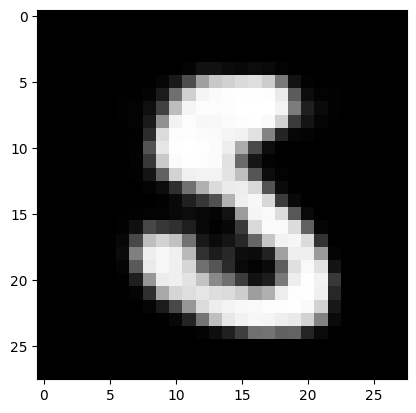

In [62]:
plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')

In [65]:
z = torch.randn((64, 4)).to(device)
images = model.decode(z)

In [72]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(torchvision.utils.make_grid(x.view(-1, 1, 28, 28).detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

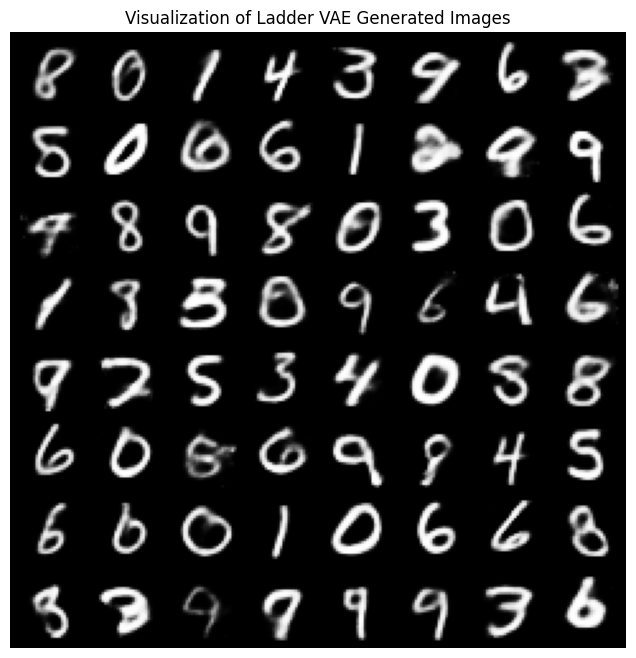

In [74]:
draw_sample_image(images, 'Ladder VAE Generated Images')